Base dataset: https://www.nist.gov/itl/products-and-services/emnist-dataset
Fine-tune attempt data:https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset 

In [ ]:
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

print("All class names:", dataset.classes)

num_samples = len(dataset)
print(f"Number of samples: {num_samples}")

Number of classes: 27
All class names: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of samples: 124800


In [ ]:
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

img_size = 28
batch_size = 64
latent_dim = 100
classes = 27

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.EMNIST(root='./data', split='letters', download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
discriminator = Discriminator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 10
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), 'generator_emnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_emnist.pth')


Epoch [0/10], Step [0/1950], D Loss: 0.6951, G Loss: 0.6875
Epoch [0/10], Step [100/1950], D Loss: 0.6622, G Loss: 0.8588
Epoch [0/10], Step [200/1950], D Loss: 0.4704, G Loss: 0.7439
Epoch [0/10], Step [300/1950], D Loss: 0.3154, G Loss: 1.2812
Epoch [0/10], Step [400/1950], D Loss: 0.5485, G Loss: 3.9611
Epoch [0/10], Step [500/1950], D Loss: 0.7338, G Loss: 0.3141
Epoch [0/10], Step [600/1950], D Loss: 0.4136, G Loss: 0.9690
Epoch [0/10], Step [700/1950], D Loss: 0.8391, G Loss: 0.2553
Epoch [0/10], Step [800/1950], D Loss: 0.5466, G Loss: 0.6184
Epoch [0/10], Step [900/1950], D Loss: 0.4858, G Loss: 0.6818
Epoch [0/10], Step [1000/1950], D Loss: 0.3120, G Loss: 2.0593
Epoch [0/10], Step [1100/1950], D Loss: 0.4526, G Loss: 3.2730
Epoch [0/10], Step [1200/1950], D Loss: 0.3718, G Loss: 2.0756
Epoch [0/10], Step [1300/1950], D Loss: 0.6178, G Loss: 0.4864
Epoch [0/10], Step [1400/1950], D Loss: 0.3762, G Loss: 1.7530
Epoch [0/10], Step [1500/1950], D Loss: 0.2464, G Loss: 1.7518
Epoc

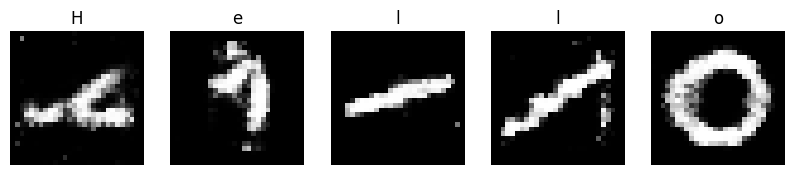

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def generate_letter(letter, model, device, latent_dim):
    label_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11,
                 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22,
                 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'N/A': 0}

    label = label_map[letter.lower()]
    z = torch.randn(1, latent_dim, device=device)
    label_tensor = torch.tensor([label], device=device)

    generated_image = model(z, label_tensor)

    return generated_image.squeeze().cpu().detach().numpy()

word = "Hello"
generated_images = []

for letter in word:
    generated_image = generate_letter(letter, generator, device, latent_dim)
    generated_images.append(generated_image)

fig, axes = plt.subplots(1, len(generated_images), figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(word[i])

plt.show()


In [ ]:
def evaluate_discriminator_accuracy(generator, discriminator, dataloader, device, latent_dim, classes):
    correct_real = 0
    correct_fake = 0
    total_real = 0
    total_fake = 0
    total_images = 0
    correct_total = 0

    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        for imgs, labels in dataloader:
            real_imgs = imgs.to(device)
            labels = labels.to(device)
            valid = torch.ones(real_imgs.size(0), 1, device=device)
            fake = torch.zeros(real_imgs.size(0), 1, device=device)

            real_preds = discriminator(real_imgs, labels)
            real_preds = real_preds.view(-1)
            real_correct = (real_preds > 0.5).float()
            correct_real += real_correct.sum().item()
            total_real += real_preds.size(0)

            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            gen_imgs = generator(z, labels)
            fake_preds = discriminator(gen_imgs, labels)
            fake_preds = fake_preds.view(-1)
            fake_correct = (fake_preds < 0.5).float()
            correct_fake += fake_correct.sum().item()
            total_fake += fake_preds.size(0)

            correct_total += real_correct.sum().item() + fake_correct.sum().item()
            total_images += real_imgs.size(0) * 2  # Two sets of images: real and generated

        real_accuracy = correct_real / total_real * 100
        fake_accuracy = correct_fake / total_fake * 100
        total_accuracy = correct_total / total_images * 100

    return real_accuracy, fake_accuracy, total_accuracy

real_accuracy, fake_accuracy, total_accuracy = evaluate_discriminator_accuracy(
    generator, discriminator, dataloader, device, latent_dim, classes)

print(f"Discriminator accuracy on real images: {real_accuracy:.2f}%")
print(f"Discriminator accuracy on fake images: {fake_accuracy:.2f}%")
print(f"Total discriminator accuracy: {total_accuracy:.2f}%")


Discriminator accuracy on real images: 51.57%
Discriminator accuracy on fake images: 96.02%
Total discriminator accuracy: 73.80%


# Fine Tuning

## Generating random data for N/A class

In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw
import random
import zipfile
from io import BytesIO

os.makedirs('N/A', exist_ok=True)

def generate_random_mark():
    img = Image.new('L', (28, 28), color=255)
    draw = ImageDraw.Draw(img)

    num_marks = random.randint(5, 15)
    for _ in range(num_marks):
        x1, y1 = random.randint(0, 27), random.randint(0, 27)
        x2, y2 = random.randint(0, 27), random.randint(0, 27)
        draw.line((x1, y1, x2, y2), fill=0, width=random.randint(1, 3))

    for _ in range(random.randint(10, 50)):
        x, y = random.randint(0, 27), random.randint(0, 27)
        img.putpixel((x, y), random.choice([0, 255]))

    return img

with zipfile.ZipFile('/content/N_A_images.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for i in range(1000):
        img = generate_random_mark()

        with BytesIO() as img_byte_arr:
            img.save(img_byte_arr, format='PNG')
            img_byte_arr.seek(0)
            zipf.writestr(f'N/A/{i:04d}.png', img_byte_arr.read())

print("1000 random 'N/A' images have been generated and saved in the 'N_A_images.zip' file.")



1000 random 'N/A' images have been generated and saved in the 'N_A_images.zip' file.


## Loading dataset

Extraction

In [ ]:
from zipfile import ZipFile
import os

zip_file_path = "zipped_handwriting_data.zip"

extracted_dir = "extracted_handwriting_data"

os.makedirs(extracted_dir, exist_ok=True)

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.printdir()

    zip_ref.extractall(extracted_dir)
    print(f'Done! Files extracted to {extracted_dir}.')



File Name                                             Modified             Size
NA/                                            2024-12-06 08:16:22            0
NA/0298.png                                    2024-12-06 08:16:22          216
NA/0267.png                                    2024-12-06 08:16:22          185
NA/0501.png                                    2024-12-06 08:16:22          229
NA/0515.png                                    2024-12-06 08:16:22          237
NA/0273.png                                    2024-12-06 08:16:22          218
NA/0529.png                                    2024-12-06 08:16:22          221
NA/0918.png                                    2024-12-06 08:16:22          241
NA/0924.png                                    2024-12-06 08:16:22          225
NA/0930.png                                    2024-12-06 08:16:22          225
NA/0703.png                                    2024-12-06 08:16:22          212
NA/0065.png                             

Data transformation

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

extracted_dir = "extracted_handwriting_data"

dataset = datasets.ImageFolder(root=extracted_dir, transform=transform)

#  renaming 'NA' to 'N/A'
dataset.classes[dataset.classes.index('NA')] = 'N/A'

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Number of samples: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")  #  should now show 'N/A', 'a', 'b', ..., 'z'


Number of samples: 3860
Number of classes: 27
Class names: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Fine tune trainng

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=27, channels=1, img_size=28, latent_dim=100).to(device)
discriminator = Discriminator(classes=27, channels=1, img_size=28, latent_dim=100).to(device)


generator.load_state_dict(torch.load('generator_emnist.pth'))
discriminator.load_state_dict(torch.load('discriminator_emnist.pth'))

print(generator)
print(discriminator)

for param in generator.model[0].parameters():
    param.requires_grad = False

for param in discriminator.model[0].parameters():
    param.requires_grad = False

generator.train()
discriminator.train()

optimizer_G = torch.optim.Adam(
    filter(lambda p: p.requires_grad, generator.parameters()),
    lr=0.00005, betas=(0.5, 0.999)
)
optimizer_D = torch.optim.Adam(
    filter(lambda p: p.requires_grad, discriminator.parameters()),
    lr=0.00005, betas=(0.5, 0.999)
)

epochs = 20
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device) * 0.9
        fake = torch.zeros(real_imgs.size(0), 1, device=device) + 0.1


        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), 100, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), 'fine_tuned_generator.pth')
torch.save(discriminator.state_dict(), 'fine_tuned_discriminator.pth')


Generator(
  (label_embedding): Embedding(27, 27)
  (model): Sequential(
    (0): Linear(in_features=127, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(27, 27)
  (adv_loss): BCELoss()
  (model): Sequential(
    (0

<ipython-input-26-459f85a5dad9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_emnist.pth'))
<ipython-input-26-459f85a5dad

Epoch [0/20], Step [0/121], D Loss: 22.4778, G Loss: 1.6418
Epoch [0/20], Step [100/121], D Loss: 3.1446, G Loss: 2.0909
Epoch [1/20], Step [0/121], D Loss: 1.6644, G Loss: 2.2818
Epoch [1/20], Step [100/121], D Loss: 1.6064, G Loss: 1.6918
Epoch [2/20], Step [0/121], D Loss: 0.9670, G Loss: 1.4930
Epoch [2/20], Step [100/121], D Loss: 0.6162, G Loss: 1.2490
Epoch [3/20], Step [0/121], D Loss: 0.5420, G Loss: 1.0941
Epoch [3/20], Step [100/121], D Loss: 0.4505, G Loss: 1.2562
Epoch [4/20], Step [0/121], D Loss: 0.4546, G Loss: 1.1641
Epoch [4/20], Step [100/121], D Loss: 0.3927, G Loss: 1.3710
Epoch [5/20], Step [0/121], D Loss: 0.4435, G Loss: 1.3514
Epoch [5/20], Step [100/121], D Loss: 0.4194, G Loss: 1.3990
Epoch [6/20], Step [0/121], D Loss: 0.4111, G Loss: 1.5334
Epoch [6/20], Step [100/121], D Loss: 0.4040, G Loss: 1.4585
Epoch [7/20], Step [0/121], D Loss: 0.4032, G Loss: 1.4028
Epoch [7/20], Step [100/121], D Loss: 0.3831, G Loss: 1.6909
Epoch [8/20], Step [0/121], D Loss: 0.4

## Testing attempt (deprecated)

Fine tuning resulted initially in extremely noisy data. After lowering the amount of data and changing the epochs, the accuracy on the original test dataset fluctuated between 20 and 60 percent on various runs.

<ipython-input-27-b4337d377edb>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('fine_tuned_generator.pth'))


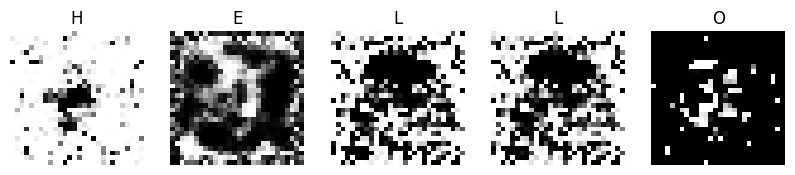

In [ ]:
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=27, channels=1, img_size=28, latent_dim=100).to(device)

generator.load_state_dict(torch.load('fine_tuned_generator.pth'))
generator.eval()

def generate_handwriting_for_word(word):
    labels = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8,
              'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
              'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22,
              'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'NA': 0}

    fig, axes = plt.subplots(1, len(word), figsize=(len(word)*2, 2))

    for i, letter in enumerate(word.upper()):
        label = torch.tensor([labels[letter]], device=device)
        z = torch.randn(1, 100, device=device)

        with torch.no_grad():
            generated_image = generator(z, label)

        generated_image = generated_image.squeeze().cpu().detach().numpy()
        axes[i].imshow(generated_image, cmap='gray')
        axes[i].set_title(f"{letter.upper()}")
        axes[i].axis('off')

    plt.show()

generate_handwriting_for_word('Hello')


## Eval (fine-tuning unsuccessful)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_dir = 'extracted_handwriting_data'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

generator = Generator(classes=27, channels=1, img_size=28, latent_dim=100).to(device)

generator.load_state_dict(torch.load('fine_tuned_generator.pth'))
generator.eval()

discriminator = Discriminator(classes=27, channels=1, img_size=28, latent_dim=100).to(device)

discriminator.load_state_dict(torch.load('fine_tuned_discriminator.pth'))
discriminator.eval()

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        z = torch.randn(imgs.size(0), 100, device=device)
        generated_imgs = generator(z, labels)

        outputs = discriminator(generated_imgs, labels)
        predicted = (outputs > 0.5).float()

        total += labels.size(0)
        correct += (predicted == labels.view(-1, 1)).sum().item()

accuracy = correct / total
print(f'Fine-tuned Model Accuracy: {accuracy * 100:.2f}%')

# Old training and eval (deprecated)

In [ ]:
epochs = 10
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs, labels = real_imgs.to(device), labels.to(device) - 1
        batch_size = real_imgs.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()

        real_preds = discriminator(real_imgs, labels)
        real_loss = discriminator.loss(real_preds, valid)

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, classes, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)
        fake_preds = discriminator(gen_imgs.detach(), gen_labels)
        fake_loss = discriminator.loss(fake_preds, fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_imgs = generator(z, gen_labels)
        g_loss = discriminator.loss(discriminator(gen_imgs, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), "generator_emnist_letters.pth")
print("Generator model saved.")

Epoch [0/10], Step [0/1950], D Loss: 1.3851, G Loss: 0.7496
Epoch [0/10], Step [100/1950], D Loss: 1.3996, G Loss: 1.1489
Epoch [0/10], Step [200/1950], D Loss: 1.1697, G Loss: 0.9255
Epoch [0/10], Step [300/1950], D Loss: 1.1794, G Loss: 0.9187
Epoch [0/10], Step [400/1950], D Loss: 1.1783, G Loss: 1.6167
Epoch [0/10], Step [500/1950], D Loss: 1.0960, G Loss: 1.1878
Epoch [0/10], Step [600/1950], D Loss: 1.2172, G Loss: 1.0286
Epoch [0/10], Step [700/1950], D Loss: 1.1738, G Loss: 1.0830
Epoch [0/10], Step [800/1950], D Loss: 1.2528, G Loss: 0.9255
Epoch [0/10], Step [900/1950], D Loss: 1.2541, G Loss: 0.9162
Epoch [0/10], Step [1000/1950], D Loss: 1.2121, G Loss: 0.8843
Epoch [0/10], Step [1100/1950], D Loss: 1.2960, G Loss: 0.8736
Epoch [0/10], Step [1200/1950], D Loss: 1.2554, G Loss: 1.0454
Epoch [0/10], Step [1300/1950], D Loss: 1.2794, G Loss: 0.9379
Epoch [0/10], Step [1400/1950], D Loss: 1.1898, G Loss: 0.9172
Epoch [0/10], Step [1500/1950], D Loss: 1.2643, G Loss: 0.9567
Epoc

<ipython-input-33-0c024905bb6a>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_emnist.pth'))
<ipython-input-33-0c024905bb6a

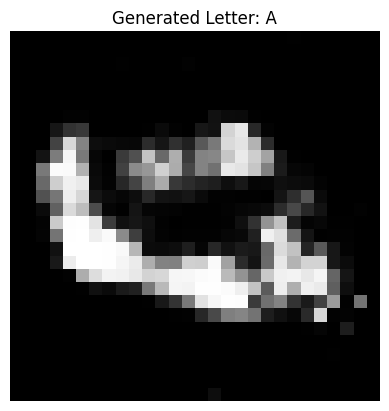

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=27, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
discriminator = Discriminator(classes=27, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)

generator.load_state_dict(torch.load('generator_emnist.pth'))
discriminator.load_state_dict(torch.load('discriminator_emnist.pth'))

generator.eval()
discriminator.eval()

z = torch.randn(1, latent_dim, device=device)
label = torch.tensor([1], device=device)

generated_image = generator(z, label)

generated_image = generated_image.squeeze().cpu().detach().numpy()

plt.imshow(generated_image, cmap='gray')
plt.title("Generated Letter: A")
plt.axis('off')
plt.show()


## Training Attempt 2

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Parameters
img_size = 28  # Resize images to 28x28
batch_size = 32
latent_dim = 100
classes = 27  # 26 letters + N/A class

# Transform for EMNIST dataset
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.EMNIST(root='./data', split='letters', download=True, transform=transform)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
discriminator = Discriminator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 10
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), 'generator_emnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_emnist.pth')


Epoch [0/10], Step [0/3900], D Loss: 0.6928, G Loss: 0.6789
Epoch [0/10], Step [100/3900], D Loss: 0.6941, G Loss: 0.7031
Epoch [0/10], Step [200/3900], D Loss: 0.4627, G Loss: 1.8025
Epoch [0/10], Step [300/3900], D Loss: 0.3638, G Loss: 0.9405
Epoch [0/10], Step [400/3900], D Loss: 0.2680, G Loss: 2.0064
Epoch [0/10], Step [500/3900], D Loss: 0.6778, G Loss: 0.4278
Epoch [0/10], Step [600/3900], D Loss: 0.6948, G Loss: 3.8600
Epoch [0/10], Step [700/3900], D Loss: 0.3698, G Loss: 2.5306
Epoch [0/10], Step [800/3900], D Loss: 0.3341, G Loss: 1.2309
Epoch [0/10], Step [900/3900], D Loss: 0.4238, G Loss: 1.0483
Epoch [0/10], Step [1000/3900], D Loss: 0.3423, G Loss: 1.4540
Epoch [0/10], Step [1100/3900], D Loss: 0.4031, G Loss: 3.0993
Epoch [0/10], Step [1200/3900], D Loss: 0.4497, G Loss: 1.1927
Epoch [0/10], Step [1300/3900], D Loss: 0.4159, G Loss: 2.1835
Epoch [0/10], Step [1400/3900], D Loss: 0.5750, G Loss: 0.6767
Epoch [0/10], Step [1500/3900], D Loss: 0.6858, G Loss: 0.5299
Epoc

<ipython-input-12-021b981a6853>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_emnist.pth'))


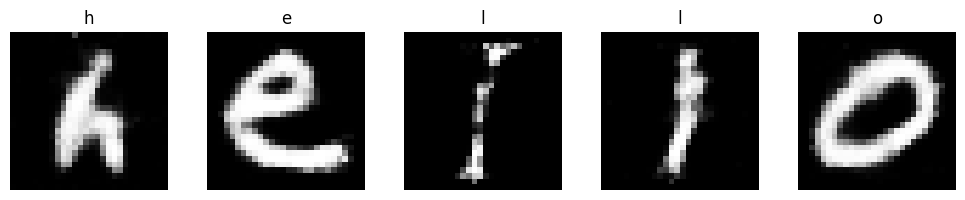

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import string

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
generator.load_state_dict(torch.load('generator_emnist.pth'))
generator.eval()

def letter_to_label(letter):
    if letter in string.ascii_lowercase:  # 'a' to 'z'
        return ord(letter) - ord('a') + 1
    return 0  # N/A for unsupported characters

word = "hello"
letters = [char for char in word]

fig, axes = plt.subplots(1, len(letters), figsize=(10, 2))
z = torch.randn(len(letters), latent_dim, device=device)  # Random noise

with torch.no_grad():
    for i, letter in enumerate(letters):
        label = letter_to_label(letter)
        label_tensor = torch.tensor([label], device=device)
        gen_img = generator(z[i].unsqueeze(0), label_tensor).squeeze(0)
        gen_img = gen_img.cpu().numpy().transpose(1, 2, 0)
        gen_img = np.flip(np.rot90(gen_img, k=-1), axis=1)
        gen_img = (gen_img + 1) / 2.0
        axes[i].imshow(gen_img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(letter)

plt.tight_layout()
plt.show()


In [ ]:
def evaluate_discriminator_accuracy(generator, discriminator, dataloader, device, latent_dim, classes):
    correct_real = 0
    correct_fake = 0
    total_real = 0
    total_fake = 0
    total_images = 0
    correct_total = 0

    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        for imgs, labels in dataloader:
            real_imgs = imgs.to(device)
            labels = labels.to(device)
            valid = torch.ones(real_imgs.size(0), 1, device=device)
            fake = torch.zeros(real_imgs.size(0), 1, device=device)

            real_preds = discriminator(real_imgs, labels)
            real_preds = real_preds.view(-1)
            real_correct = (real_preds > 0.5).float()
            correct_real += real_correct.sum().item()
            total_real += real_preds.size(0)

            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            gen_imgs = generator(z, labels)
            fake_preds = discriminator(gen_imgs, labels)
            fake_preds = fake_preds.view(-1)
            fake_correct = (fake_preds < 0.5).float()
            correct_fake += fake_correct.sum().item()
            total_fake += fake_preds.size(0)

            correct_total += real_correct.sum().item() + fake_correct.sum().item()
            total_images += real_imgs.size(0) * 2  # Two sets of images: real and generated

        real_accuracy = correct_real / total_real * 100
        fake_accuracy = correct_fake / total_fake * 100
        total_accuracy = correct_total / total_images * 100

    return real_accuracy, fake_accuracy, total_accuracy

real_accuracy, fake_accuracy, total_accuracy = evaluate_discriminator_accuracy(
    generator, discriminator, dataloader, device, latent_dim, classes)

print(f"Discriminator accuracy on real images: {real_accuracy:.2f}%")
print(f"Discriminator accuracy on fake images: {fake_accuracy:.2f}%")
print(f"Total discriminator accuracy: {total_accuracy:.2f}%")


Discriminator accuracy on real images: 74.76%
Discriminator accuracy on fake images: 68.72%
Total discriminator accuracy: 71.74%


After increasing generator learning rate:

Epoch [0/10], Step [0/3900], D Loss: 0.6909, G Loss: 0.7329
Epoch [0/10], Step [100/3900], D Loss: 0.8231, G Loss: 0.4515
Epoch [0/10], Step [200/3900], D Loss: 0.5392, G Loss: 3.5604
Epoch [0/10], Step [300/3900], D Loss: 0.3023, G Loss: 1.5572
Epoch [0/10], Step [400/3900], D Loss: 0.4301, G Loss: 0.7621
Epoch [0/10], Step [500/3900], D Loss: 0.2499, G Loss: 1.2556
Epoch [0/10], Step [600/3900], D Loss: 0.5376, G Loss: 3.2664
Epoch [0/10], Step [700/3900], D Loss: 0.4370, G Loss: 3.4916
Epoch [0/10], Step [800/3900], D Loss: 0.3965, G Loss: 1.2860
Epoch [0/10], Step [900/3900], D Loss: 0.3682, G Loss: 1.9953
Epoch [0/10], Step [1000/3900], D Loss: 0.6190, G Loss: 3.1777
Epoch [0/10], Step [1100/3900], D Loss: 0.4534, G Loss: 2.4868
Epoch [0/10], Step [1200/3900], D Loss: 0.3303, G Loss: 1.5474
Epoch [0/10], Step [1300/3900], D Loss: 0.3278, G Loss: 1.2608
Epoch [0/10], Step [1400/3900], D Loss: 0.3839, G Loss: 1.1070
Epoch [0/10], Step [1500/3900], D Loss: 0.2999, G Loss: 2.1807
Epoc

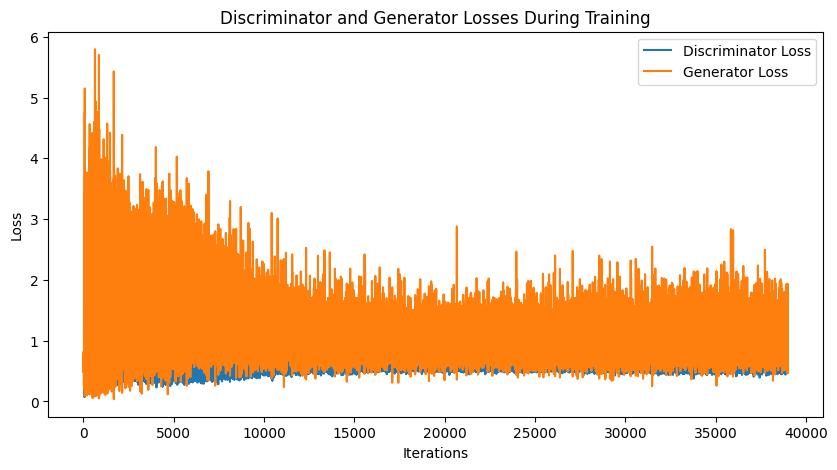

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

img_size = 28
batch_size = 32
latent_dim = 100
classes = 27

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.EMNIST(root='./data', split='letters', download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
discriminator = Discriminator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_losses = []
g_losses = []

epochs = 10
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), 'generator_emnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_emnist.pth')

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Discriminator and Generator Losses During Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [0/10], Step [0/3900], D Loss: 0.5622, G Loss: 1.3094
Epoch [0/10], Step [100/3900], D Loss: 0.5625, G Loss: 1.1750
Epoch [0/10], Step [200/3900], D Loss: 0.5715, G Loss: 1.1213
Epoch [0/10], Step [300/3900], D Loss: 0.5441, G Loss: 0.9150
Epoch [0/10], Step [400/3900], D Loss: 0.5266, G Loss: 1.1181
Epoch [0/10], Step [500/3900], D Loss: 0.5595, G Loss: 0.8731
Epoch [0/10], Step [600/3900], D Loss: 0.5390, G Loss: 1.3248
Epoch [0/10], Step [700/3900], D Loss: 0.5648, G Loss: 0.8926
Epoch [0/10], Step [800/3900], D Loss: 0.5718, G Loss: 0.9986
Epoch [0/10], Step [900/3900], D Loss: 0.5071, G Loss: 1.0903
Epoch [0/10], Step [1000/3900], D Loss: 0.5144, G Loss: 1.0112
Epoch [0/10], Step [1100/3900], D Loss: 0.5929, G Loss: 1.2510
Epoch [0/10], Step [1200/3900], D Loss: 0.5845, G Loss: 0.8713
Epoch [0/10], Step [1300/3900], D Loss: 0.6638, G Loss: 1.6328
Epoch [0/10], Step [1400/3900], D Loss: 0.5359, G Loss: 0.8962
Epoch [0/10], Step [1500/3900], D Loss: 0.6406, G Loss: 0.6300
Epoc

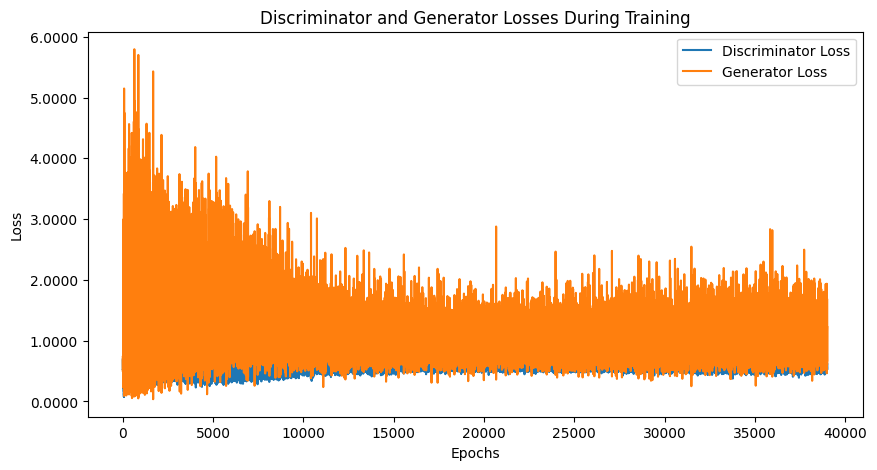

In [ ]:
epochs = 10
for epoch in range(epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    avg_d_loss = d_loss_epoch / len(dataloader)
    avg_g_loss = g_loss_epoch / len(dataloader)

    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

torch.save(generator.state_dict(), 'generator_emnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_emnist.pth')

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Discriminator and Generator Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))

plt.legend()
plt.show()


Epoch [1/10] Training D Loss: 0.4445, Validation D Loss: 0.4128, Training G Loss: 1.6020, Validation G Loss: 1.2322
Epoch [2/10] Training D Loss: 0.4484, Validation D Loss: 0.4123, Training G Loss: 1.5844, Validation G Loss: 1.0897
Epoch [3/10] Training D Loss: 0.4681, Validation D Loss: 0.4599, Training G Loss: 1.4742, Validation G Loss: 1.4778
Epoch [4/10] Training D Loss: 0.5360, Validation D Loss: 0.5381, Training G Loss: 1.1933, Validation G Loss: 0.8455
Epoch [5/10] Training D Loss: 0.5696, Validation D Loss: 0.5557, Training G Loss: 1.0719, Validation G Loss: 1.0132
Epoch [6/10] Training D Loss: 0.5772, Validation D Loss: 0.6261, Training G Loss: 1.0461, Validation G Loss: 1.4720
Epoch [7/10] Training D Loss: 0.5782, Validation D Loss: 0.6822, Training G Loss: 1.0398, Validation G Loss: 0.5120
Epoch [8/10] Training D Loss: 0.5764, Validation D Loss: 0.5518, Training G Loss: 1.0484, Validation G Loss: 0.8913
Epoch [9/10] Training D Loss: 0.5713, Validation D Loss: 0.5467, Trainin

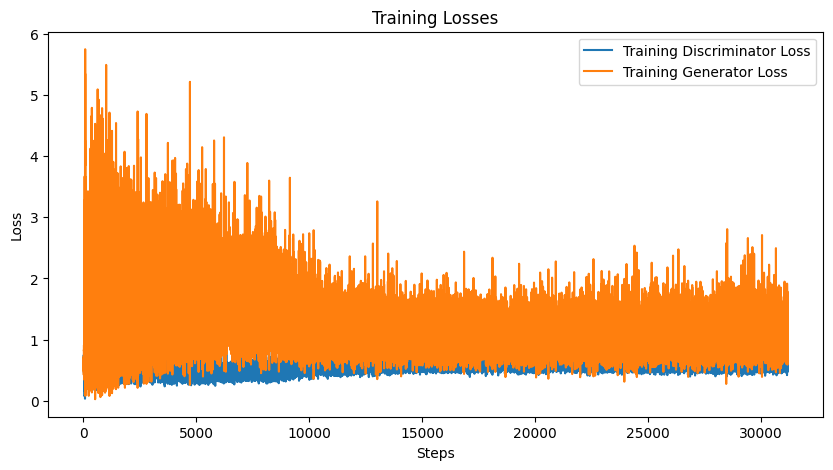

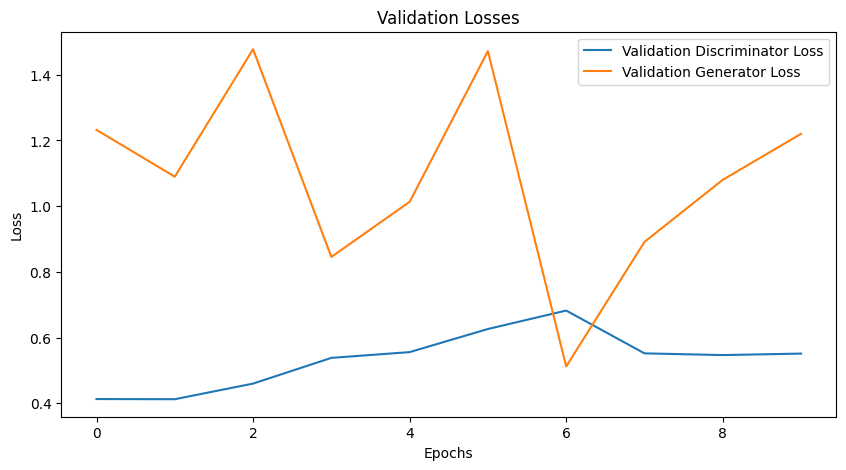

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt

img_size = 28
batch_size = 32
latent_dim = 100
classes = 27
epochs = 10
val_split = 0.2

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.EMNIST(root='./data', split='letters', download=True, transform=transform)
train_size = int(len(dataset) * (1 - val_split))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
discriminator = Discriminator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

training_d_losses = []
validation_d_losses = []
training_g_losses = []
validation_g_losses = []
steps = []

step = 0
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    for i, (imgs, labels) in enumerate(train_loader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z, labels)

        g_loss = discriminator.loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = discriminator.loss(discriminator(real_imgs, labels), valid)

        fake_loss = discriminator.loss(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        training_d_losses.append(d_loss.item())
        training_g_losses.append(g_loss.item())
        steps.append(step)
        step += 1

    generator.eval()
    discriminator.eval()
    val_d_loss, val_g_loss = 0.0, 0.0
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            valid_val = torch.ones(val_imgs.size(0), 1, device=device)
            fake_val = torch.zeros(val_imgs.size(0), 1, device=device)
            z_val = torch.randn(val_imgs.size(0), latent_dim, device=device)
            gen_val_imgs = generator(z_val, val_labels)

            real_val_loss = discriminator.loss(discriminator(val_imgs, val_labels), valid_val)
            fake_val_loss = discriminator.loss(discriminator(gen_val_imgs, val_labels), fake_val)
            val_d_loss += (real_val_loss + fake_val_loss).item() / 2

            val_g_loss += discriminator.loss(discriminator(gen_val_imgs, val_labels), valid_val).item()

        validation_d_losses.append(val_d_loss / len(val_loader))
        validation_g_losses.append(val_g_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{epochs}] Training D Loss: {np.mean(training_d_losses[-len(train_loader):]):.4f}, "
          f"Validation D Loss: {validation_d_losses[-1]:.4f}, "
          f"Training G Loss: {np.mean(training_g_losses[-len(train_loader):]):.4f}, "
          f"Validation G Loss: {validation_g_losses[-1]:.4f}")

df = pd.DataFrame({
    'Step': steps,
    'Training D Loss': training_d_losses,
    'Validation D Loss': validation_d_losses * len(train_loader),
    'Training G Loss': training_g_losses,
    'Validation G Loss': validation_g_losses * len(train_loader)
})

print(df)
df.to_csv('training_validation_losses.csv', index=False)

plt.figure(figsize=(10, 5))
plt.plot(steps, training_d_losses, label='Training Discriminator Loss')
plt.plot(steps, training_g_losses, label='Training Generator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), validation_d_losses, label='Validation Discriminator Loss')
plt.plot(range(epochs), validation_g_losses, label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()
plt.show()


<ipython-input-42-239fe4dada21>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_emnist.pth'))


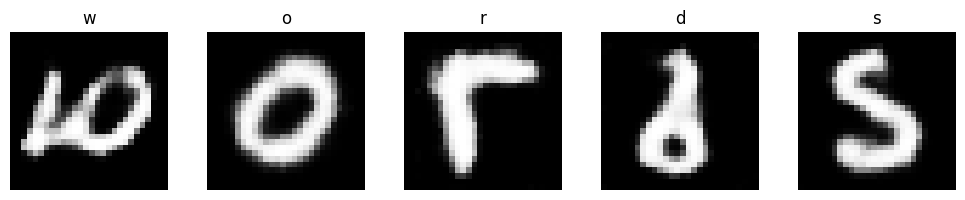

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import string

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
generator.load_state_dict(torch.load('generator_emnist.pth'))
generator.eval()

def letter_to_label(letter):
    if letter in string.ascii_lowercase:
        return ord(letter) - ord('a') + 1
    return 0

word = "words"
letters = [char for char in word]

fig, axes = plt.subplots(1, len(letters), figsize=(10, 2))
z = torch.randn(len(letters), latent_dim, device=device)

with torch.no_grad():
    for i, letter in enumerate(letters):
        label = letter_to_label(letter)
        label_tensor = torch.tensor([label], device=device)
        gen_img = generator(z[i].unsqueeze(0), label_tensor).squeeze(0)
        gen_img = gen_img.cpu().numpy().transpose(1, 2, 0)
        gen_img = np.flip(np.rot90(gen_img, k=-1), axis=1)
        gen_img = (gen_img + 1) / 2.0
        axes[i].imshow(gen_img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(letter)

plt.tight_layout()
plt.show()

<ipython-input-48-85b08313b792>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_emnist.pth'))


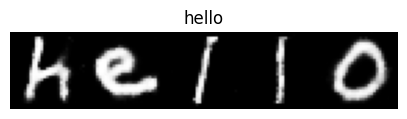

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import string

generator = Generator(classes=classes, channels=1, img_size=img_size, latent_dim=latent_dim).to(device)
generator.load_state_dict(torch.load('generator_emnist.pth'))
generator.eval()

def letter_to_label(letter):
    if letter in string.ascii_lowercase:
        return ord(letter) - ord('a') + 1
    return 0
def generate_word_image(generator, word, latent_dim, img_size, device):
    letters = [char for char in word]
    z = torch.randn(len(letters), latent_dim, device=device)
    generated_images = []
    with torch.no_grad():
        for i, letter in enumerate(letters):
            label = letter_to_label(letter)
            label_tensor = torch.tensor([label], device=device)
            gen_img = generator(z[i].unsqueeze(0), label_tensor).squeeze(0)
            gen_img = gen_img.cpu().numpy().squeeze(0)

            gen_img = np.flip(np.rot90(gen_img, k=-1), axis=1)

            gen_img = (gen_img + 1) / 2.0

            generated_images.append(gen_img)

    word_image = np.concatenate(generated_images, axis=1)

    plt.figure(figsize=(len(letters), 2))
    plt.imshow(word_image, cmap='gray')
    plt.axis('off')
    plt.title(word)
    plt.show()

word = "hello"
generate_word_image(generator, word, latent_dim, img_size, device)
